In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix,mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import os.path
from pathlib import Path

2025-04-16 09:17:37.613001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744795057.878701      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744795057.944393      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
img_dir_M = Path('/kaggle/input/fruit-yield/FruitYield DataSet/Sweetness')
path_M = 'Sweetness/'

In [4]:
img_dir_M = Path('/kaggle/input/fruit-yield/FruitYield DataSet/Sweetness')
csv_path = img_dir_M / 'sweet3.csv'
data = pd.read_csv(csv_path)
print(data.columns)


Index(['Filepath', 'Sweetness', 'Calories(Kcal/100g)', 'Vitamin_C(mg/100g)'], dtype='object')


In [5]:
# Assuming 'Filepath' and 'Sweetness' are valid column names in the CSV
image_paths = data['Filepath'].values
sweet = data['Sweetness'].values

# If needed, uncomment below lines when those columns are present:
# weights = data['Sweetness'].values  # Redundant, same as `sweet`
# cal = data['Calories(Kcal/100g)'].values
# Vit_C = data['Vitamin _C(mg/100g)'].values


In [6]:
img_dir_M = Path('/kaggle/input/fruit-yield/FruitYield DataSet/Sweetness')  # or one level up

images = []
for image_path in image_paths:
    image_path = Path(image_path).name  # ensures only filename
    full_path = img_dir_M / image_path

    image = tf.keras.preprocessing.image.load_img(full_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    images.append(image)

images = np.array(images)

In [7]:
from sklearn.model_selection import train_test_split

# Ensure image_paths is a list or numpy array
image_paths = np.array(image_paths)

# Split the dataset
X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
    images, sweet, image_paths, test_size=0.2, random_state=42
)


In [8]:
base_model = EfficientNetB0(
    weights='imagenet',         # Use pre-trained weights from ImageNet
    include_top=False,          # Exclude the final classification layer
    input_shape=(224, 224, 3)   # Match your input image shape
)



I0000 00:00:1744795312.604087      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744795312.604736      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
# Create the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    #Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    #Dropout(0.2),
    Dense(1, activation='sigmoid')
    #Dense(1)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,165,476 (19.70 MB)

 Trainable params: 5,123,453 (19.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [10]:
# Compile the model
model.compile(optimizer=Adam(0.0001), loss='mean_squared_error')

In [12]:
# Define callbacks
checkpoint = ModelCheckpoint('Sweet_single_best_modelnew.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [13]:
# Train the model
history = model.fit(X_train, y_train, batch_size=4, epochs=70,validation_data=(X_test, y_test), callbacks=[checkpoint,early_stopping])

Epoch 1/50


I0000 00:00:1744795524.006843     105 service.cc:148] XLA service 0x7a69ec0ab1e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744795524.007756     105 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744795524.007778     105 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744795528.693729     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/299 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.2032    

I0000 00:00:1744795554.961445     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0229
Epoch 1: val_loss improved from inf to 0.00490, saving model to Sweet_single_best_model.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 97s 45ms/step - loss: 0.0229 - val_loss: 0.0049
Epoch 2/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.3141e-05
Epoch 2: val_loss improved from 0.00490 to 0.00435, saving model to Sweet_single_best_model.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.3139e-05 - val_loss: 0.0044
Epoch 3/50
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0361e-05
Epoch 3: val_loss improved from 0.00435 to 0.00351, saving model to Sweet_single_best_model.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.0363e-05 - val_loss: 0.0035
Epoch 4/50
298/299 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0460e-05
Epoch 4: val_loss improved from 0.00351 to 0.00327, saving model to Sweet_single_best_model.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.0460e-05 - val_loss: 0.0033
Epoch 5/50
298/299 ━━━

In [2]:
model.load_weights('Sweet_single_best_model.keras')

In [3]:
# Evaluate the model
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


In [4]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)


Mean Squared Error: 3.980796529398798e-06
Mean Absolute Error: 0.001473639818748629
R^2 Score: 0.4681387916721741


In [5]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = accuracy_score(np.round(y_test), np.round(y_pred))

# Display metrics
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Accuracy: {accuracy}')


Mean Squared Error: 3.980796529398798e-06
R-squared: 0.4681387916721741
Accuracy: 1.0


In [1]:
# Train the model
history = model.fit(X_train, y_train, batch_size=4, epochs=70,validation_data=(X_test, y_test), callbacks=[checkpoint,early_stopping])

Epoch 1/70


I0000 00:00:1744796957.928151      73 service.cc:148] XLA service 0x7f59d80ce9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744796957.929082      73 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744796957.929101      73 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744796962.816237      73 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1744796970.172087      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744796970.305917      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  3/150 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 3.2871e-06    

I0000 00:00:1744796990.220549      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - loss: 2.6844e-06
Epoch 1: val_loss improved from 0.00001 to 0.00000, saving model to Sweet_single_best_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 99s 294ms/step - loss: 2.6837e-06 - val_loss: 3.9808e-06
Epoch 2/70
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 2.3792e-06
Epoch 2: val_loss did not improve from 0.00000
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 2.3763e-06 - val_loss: 5.0164e-06
Epoch 3/70
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 1.6702e-06
Epoch 3: val_loss did not improve from 0.00000
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 1.6705e-06 - val_loss: 7.5516e-06
Epoch 4/70
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.8920e-06
Epoch 4: val_loss did not improve from 0.00000
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 1.8918e-06 - val_loss: 8.4562e-06
Epoch 5/70
148/150 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.6530e-06
Epoch 5: val_loss did not improve from 0.00000
150/150 ━━━━━━━━━━━━━━━━━━

In [6]:
# Display some actual and predicted data
y_pred1=y_pred.tolist()
results = pd.DataFrame({'Image Path': paths_test, 'Actual Sweetness': y_test, 'Predicted Sweetness': y_pred1})
print(results.head(60))

                Image Path  Actual Sweetness       Predicted Sweetness
0     Sweetness/WRA _3.jpg            0.0075    [0.008135132491588593]
1   Sweetness/URB _100.jpg            0.0019   [0.0007465079543180764]
2    Sweetness/URB _55.jpg            0.0022    [0.001647230121307075]
3    Sweetness/URB _32.jpg            0.0025   [0.0009421724244020879]
4    Sweetness/URB _44.jpg            0.0019   [0.0026490665040910244]
5    Sweetness/URB _58.jpg            0.0021   [0.0009382187854498625]
6    Sweetness/URA _70.jpg            0.0011   [0.0018131403485313058]
7   Sweetness/PRB _117.jpg            0.0045   [0.0033802019897848368]
8    Sweetness/PRA _62.jpg            0.0038   [0.0029594232328236103]
9    Sweetness/URB _39.jpg            0.0017    [0.001451002317480743]
10   Sweetness/WRB _91.jpg            0.0089    [0.004822791554033756]
11   Sweetness/URB _31.jpg            0.0023   [0.0015893763629719615]
12  Sweetness/PRB _101.jpg            0.0044    [0.002312358934432268]
13   S

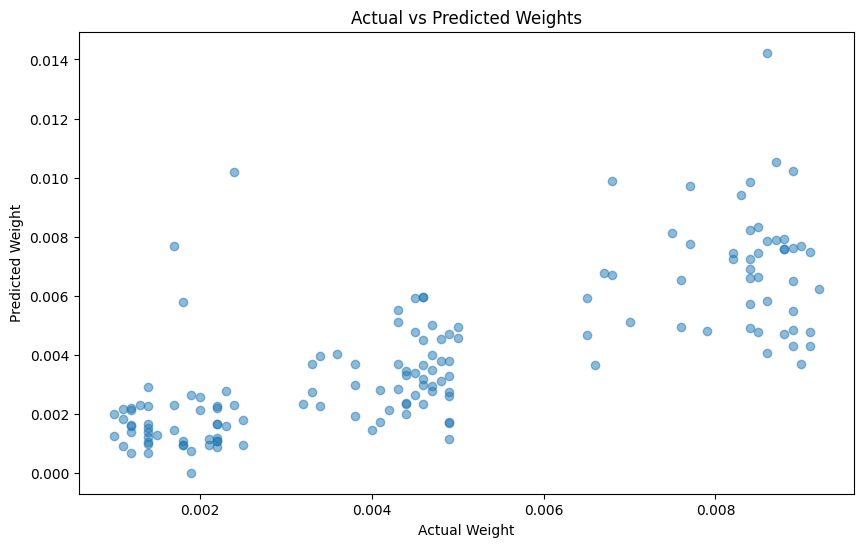

In [7]:
# Plot scatter plot of actual vs predicted weights
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Weight')
plt.ylabel('Predicted Weight')
plt.title('Actual vs Predicted Weights')
plt.show()

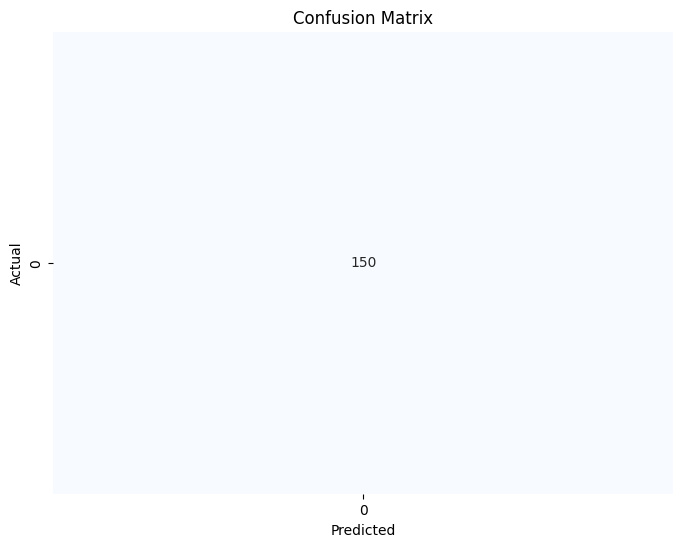

In [8]:
# Plot confusion matrix
cm = confusion_matrix(np.round(y_test), np.round(y_pred))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix,mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import os.path
from pathlib import Path

In [4]:
img_dir_M = Path('/kaggle/input/fruit-yield/FruitYield DataSet/Sweetness')
path_M = 'Sweetness/'

In [5]:
img_dir_M = Path('/kaggle/input/fruit-yield/FruitYield DataSet/Sweetness')
csv_path = img_dir_M / 'sweet.csv'
data = pd.read_csv(csv_path)
print(data.columns)

Index(['Filepath', 'Sweetness', 'Calories(Kcal/100g)', 'Vitamin _C(mg/100g)'], dtype='object')


In [6]:
# Assuming 'Filepath' and 'Sweetness' are valid column names in the CSV
image_paths = data['Filepath'].values
sweet = data['Sweetness'].values

# If needed, uncomment below lines when those columns are present:
# weights = data['Sweetness'].values  # Redundant, same as `sweet`
# cal = data['Calories(Kcal/100g)'].values
# Vit_C = data['Vitamin _C(mg/100g)'].values




In [7]:
img_dir_M = Path('/kaggle/input/fruit-yield/FruitYield DataSet/Sweetness')  # or one level up

images = []
for image_path in image_paths:
    image_path = Path(image_path).name  # ensures only filename
    full_path = img_dir_M / image_path

    image = tf.keras.preprocessing.image.load_img(full_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    images.append(image)

images = np.array(images)



In [8]:
from sklearn.model_selection import train_test_split

# Ensure image_paths is a list or numpy array
image_paths = np.array(image_paths)

# Split the dataset
X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
    images, sweet, image_paths, test_size=0.2, random_state=42
)



In [9]:
base_model = EfficientNetB0(
    weights='imagenet',         # Use pre-trained weights from ImageNet
    include_top=False,          # Exclude the final classification layer
    input_shape=(224, 224, 3)   # Match your input image shape
)



16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
# Create the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    #Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    #Dropout(0.2),
    Dense(1, activation='sigmoid')
    #Dense(1)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,165,476 (19.70 MB)

 Trainable params: 5,123,453 (19.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [11]:
# Compile the model
model.compile(optimizer=Adam(0.0001), loss='mean_squared_error')

In [12]:
# Define callbacks
checkpoint = ModelCheckpoint('Sweet_single_best1_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [13]:
# Train the model
history = model.fit(X_train, y_train, batch_size=4, epochs=70,validation_data=(X_test, y_test), callbacks=[checkpoint,early_stopping])

Epoch 1/70


I0000 00:00:1744798402.545776      73 service.cc:148] XLA service 0x7bda20003e20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744798402.548325      73 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744798402.548344      73 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744798407.565884      73 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1744798415.238711      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1744798415.372820      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  3/150 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0579    

I0000 00:00:1744798435.459055      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


150/150 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - loss: 0.0448
Epoch 1: val_loss improved from inf to 0.06055, saving model to Sweet_single_best1_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 129s 290ms/step - loss: 0.0447 - val_loss: 0.0606
Epoch 2/70
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0159
Epoch 2: val_loss improved from 0.06055 to 0.01654, saving model to Sweet_single_best1_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0159 - val_loss: 0.0165
Epoch 3/70
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0092
Epoch 3: val_loss improved from 0.01654 to 0.00957, saving model to Sweet_single_best1_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.0092 - val_loss: 0.0096
Epoch 4/70
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0135
Epoch 4: val_loss improved from 0.00957 to 0.00881, saving model to Sweet_single_best1_model.keras
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0135 - val_loss: 0.0088
Epoch 5/70
150/150 ━━━━━━━━━━━━━━━━━━━━

In [14]:
model.load_weights('Sweet_single_best1_model.keras')

In [15]:
# Evaluate the model
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step


In [16]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)


Mean Squared Error: 0.020371019532878468
Mean Absolute Error: 0.10209583612283071
R^2 Score: 0.7317488214893099


In [17]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = accuracy_score(np.round(y_test), np.round(y_pred))

# Display metrics
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Accuracy: {accuracy}')


Mean Squared Error: 0.020371019532878468
R-squared: 0.7317488214893099
Accuracy: 0.8866666666666667


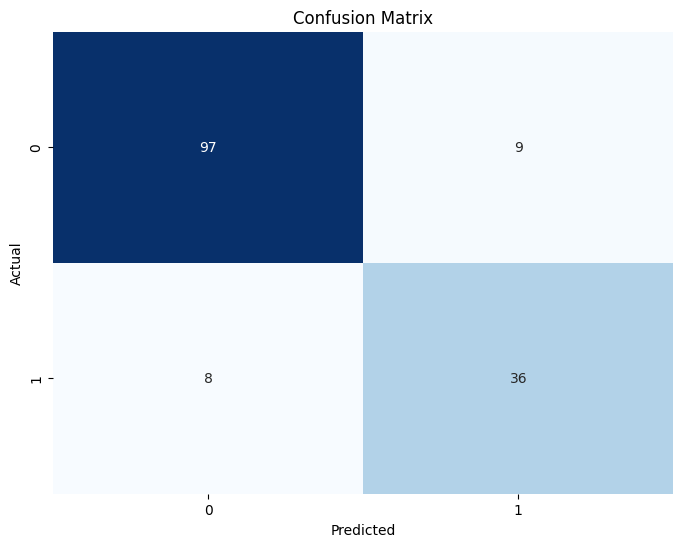

In [18]:
# Plot confusion matrix
cm = confusion_matrix(np.round(y_test), np.round(y_pred))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Display some actual and predicted data
y_pred1=y_pred.tolist()
results = pd.DataFrame({'Image Path': paths_test, 'Actual Sweetness': y_test, 'Predicted Sweetness': y_pred1})
print(results.head(60))

                Image Path  Actual Sweetness    Predicted Sweetness
0    Sweetness/WRB _19.jpg              0.85   [0.6657642126083374]
1    Sweetness/PRB _36.jpg              0.44   [0.4544830024242401]
2     Sweetness/URB _7.jpg              0.25  [0.17929108440876007]
3     Sweetness/PRA _1.jpg              0.33   [0.3327162563800812]
4    Sweetness/PRA _50.jpg              0.41  [0.24223178625106812]
5    Sweetness/PRB _68.jpg              0.43   [0.6079877614974976]
6    Sweetness/PRB _16.jpg              0.49  [0.43082281947135925]
7    Sweetness/URB _29.jpg              0.23  [0.16044805943965912]
8    Sweetness/WRA _28.jpg              0.70   [0.5469221472740173]
9   Sweetness/WRB _173.jpg              0.85   [0.8510564565658569]
10   Sweetness/URA _98.jpg              0.13  [0.17415955662727356]
11   Sweetness/PRA _57.jpg              0.32   [0.3773774802684784]
12   Sweetness/PRA _32.jpg              0.32   [0.3425680100917816]
13  Sweetness/WRB _183.jpg              0.85   [

In [21]:
# Create the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    #Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    #Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(256, activation='relu'),
    #Dropout(0.2),
    Dense(1, activation='sigmoid')
    #Dense(1)
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,902,820 (18.70 MB)

 Trainable params: 4,860,797 (18.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [23]:
model.compile(optimizer=Adam(0.0001), loss='mean_squared_error')

In [20]:
# Define callbacks
checkpoint = ModelCheckpoint('Sweet_single_best2_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)


In [24]:
# Train the model
history = model.fit(X_train, y_train, batch_size=2, epochs=70,validation_data=(X_test, y_test), callbacks=[checkpoint])

Epoch 1/70
298/299 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0211
Epoch 1: val_loss improved from inf to 0.00752, saving model to Sweet_single_best2_model.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 91s 45ms/step - loss: 0.0210 - val_loss: 0.0075
Epoch 2/70
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0047
Epoch 2: val_loss did not improve from 0.00752
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0047 - val_loss: 0.0108
Epoch 3/70
298/299 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0038
Epoch 3: val_loss did not improve from 0.00752
299/299 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0038 - val_loss: 0.0143
Epoch 4/70
298/299 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0033
Epoch 4: val_loss improved from 0.00752 to 0.00634, saving model to Sweet_single_best2_model.keras
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0033 - val_loss: 0.0063
Epoch 5/70
297/299 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0030
Epoch 5: val_loss did not improve from 0.00634
299/299 ━━━━━━━━━━━━

In [25]:
model.load_weights('Sweet_single_best2_model.keras')

In [26]:
# Evaluate the model
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step


In [27]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display metrics
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R^2 Score:", r2)


Mean Squared Error: 0.004480841560508222
Mean Absolute Error: 0.04718933770457903
R^2 Score: 0.9409950480197607


In [28]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
accuracy = accuracy_score(np.round(y_test), np.round(y_pred))

# Display metrics
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')
print(f'Accuracy: {accuracy}')


Mean Squared Error: 0.004480841560508222
R-squared: 0.9409950480197607
Accuracy: 0.96


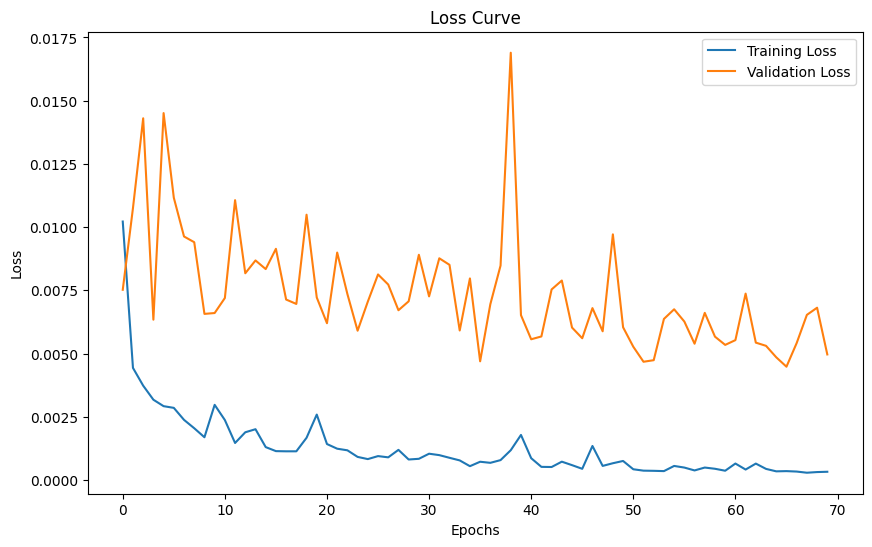

In [30]:
# Plot loss curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

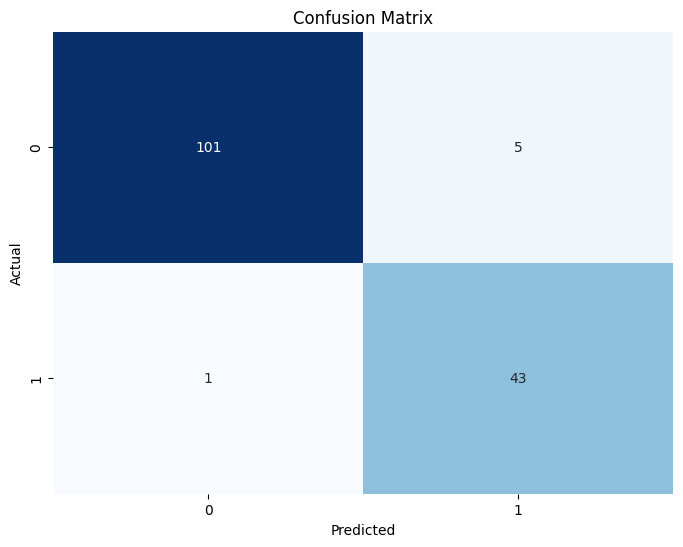

In [31]:
# Plot confusion matrix
cm = confusion_matrix(np.round(y_test), np.round(y_pred))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

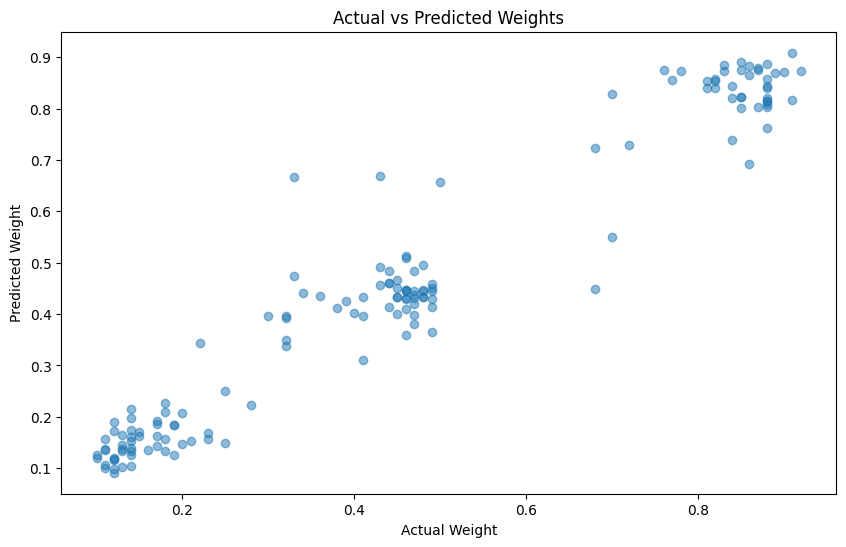

In [32]:
# Plot scatter plot of actual vs predicted weights
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Weight')
plt.ylabel('Predicted Weight')
plt.title('Actual vs Predicted Weights')
plt.show()

In [29]:
# Display some actual and predicted data
y_pred1=y_pred.tolist()
results = pd.DataFrame({'Image Path': paths_test, 'Actual Sweetness': y_test, 'Predicted Sweetness': y_pred1})
print(results.head(60))

                Image Path  Actual Sweetness    Predicted Sweetness
0    Sweetness/WRB _19.jpg              0.85   [0.8227580785751343]
1    Sweetness/PRB _36.jpg              0.44   [0.4603732228279114]
2     Sweetness/URB _7.jpg              0.25  [0.25031766295433044]
3     Sweetness/PRA _1.jpg              0.33   [0.6662645936012268]
4    Sweetness/PRA _50.jpg              0.41   [0.3116028606891632]
5    Sweetness/PRB _68.jpg              0.43  [0.49121037125587463]
6    Sweetness/PRB _16.jpg              0.49  [0.45855575799942017]
7    Sweetness/URB _29.jpg              0.23  [0.16863693296909332]
8    Sweetness/WRA _28.jpg              0.70   [0.8283724188804626]
9   Sweetness/WRB _173.jpg              0.85   [0.8751721382141113]
10   Sweetness/URA _98.jpg              0.13  [0.14425048232078552]
11   Sweetness/PRA _57.jpg              0.32   [0.3384109139442444]
12   Sweetness/PRA _32.jpg              0.32   [0.3916392922401428]
13  Sweetness/WRB _183.jpg              0.85   [